In [1]:
import os
import numpy as np
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
from astropy import units as u
import sys
sys.path.append('../edge_pydb')
from edge_conv import stmass_pc2, msd_co, sfr_ha, xy2hist
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Depletion time vs stellar surface density for EDGE.  

In [2]:
if os.path.exists('../img_califa/edge.pipe3d.hdf5'):
    print('Working on full EDGE database')
    hafile = '../img_califa/edge.pipe3d.hdf5'
    cofile = '../img_comom/edge.comom_smo7.hdf5'
else:
    print('Working on NGC 4047 data')
    hafile = '../img_califa/NGC4047.pipe3d.hdf5'
    cofile = '../img_comom/NGC4047.comom_smo7.hdf5'

Working on full EDGE database


In [3]:
cotab=Table.read(cofile, path='smo')
hatab=Table.read(hafile, path='flux_elines_sm')
sttab=Table.read(hafile, path='SSP_sm')
join2 = join(cotab,hatab)
join3 = join(join2,sttab)
# For stellar surface density we need distance
globaldir = '../dat_glob/'
califa = Table.read(globaldir+'external/edge_califa.csv', format='ascii.ecsv')
dists = Table([califa['Name'], califa['caDistMpc']])
join4 = join(join3,dists,keys='Name')
print(join4.colnames)

['Name', 'ix', 'iy', 'ra_off', 'dec_off', 'emom0max', 'mom0', 'emom0', 'flux_[OII]3727', 'flux_[OIII]5007', 'flux_[OIII]4959', 'flux_Hbeta', 'flux_Halpha', 'flux_[NII]6583', 'flux_[NII]6548', 'flux_[SII]6717', 'flux_[SII]6731', 'vel_[OII]3727', 'vel_[OIII]5007', 'vel_[OIII]4959', 'vel_Hbeta', 'vel_Halpha', 'vel_[NII]6583', 'vel_[NII]6548', 'vel_[SII]6717', 'vel_[SII]6731', 'disp_[OII]3727', 'disp_[OIII]5007', 'disp_[OIII]4959', 'disp_Hbeta', 'disp_Halpha', 'disp_[NII]6583', 'disp_[NII]6548', 'disp_[SII]6717', 'disp_[SII]6731', 'EW_[OII]3727', 'EW_[OIII]5007', 'EW_[OIII]4959', 'EW_Hbeta', 'EW_Halpha', 'EW_[NII]6583', 'EW_[NII]6548', 'EW_[SII]6717', 'EW_[SII]6731', 'e_flux_[OII]3727', 'e_flux_[OIII]5007', 'e_flux_[OIII]4959', 'e_flux_Hbeta', 'e_flux_Halpha', 'e_flux_[NII]6583', 'e_flux_[NII]6548', 'e_flux_[SII]6717', 'e_flux_[SII]6731', 'e_vel_[OII]3727', 'e_vel_[OIII]5007', 'e_vel_[OIII]4959', 'e_vel_Hbeta', 'e_vel_Halpha', 'e_vel_[NII]6583', 'e_vel_[NII]6548', 'e_vel_[SII]6717', 'e_vel

In [4]:
# Derived quantities for the CO detections
det = (join4['mom0']>3*join4['emom0']) & (join4['flux_Halpha']>3*join4['e_flux_Halpha'])
sig_mol = msd_co(join4['mom0'][det], name='sig_mol')
sig_sfr = sfr_ha(join4['flux_Halpha'][det],join4['flux_Hbeta'][det], name='sig_sfr')
t_dep = Column(sig_mol.quantity/sig_sfr.quantity, name='t_dep')
print('Number of CO and Ha detections:',len(t_dep))
sig_star = stmass_pc2(join4['mass_ssp'][det], 
            dist=join4['caDistMpc'][det].quantity, name='sig_star')
sig_ssfr = Column(sig_sfr.quantity/sig_star.quantity, name='sig_ssfr')
Table([sig_mol,sig_sfr,t_dep,sig_star,sig_ssfr]).pprint(max_width=100)

Number of CO and Ha detections: 4805
   sig_mol          sig_sfr           t_dep        sig_star       sig_ssfr   
solMass / pc2 solMass / (Gyr pc2)      Gyr      solMass / pc2     1 / Gyr    
------------- ------------------- ------------- ------------- ---------------
      20.6214                 nan           nan 36.7150181086             nan
      41.5198                 nan           nan 43.7367346797             nan
      32.7552       19.5884140414 1.67217307315 53.7130420058  0.364686364986
      16.4682       2.72586384026 6.04144442727 44.3558419088 0.0614544493567
      26.1644       29.3760363015 0.89067208016 23.2132320631   1.26548669404
      22.4153        4.2120329615 5.32172957196 43.1519873069 0.0976092463954
      10.5689                 nan           nan 26.7522395386             nan
      23.7059                 nan           nan 83.7100783757             nan
      63.9817                 nan           nan    155.736378             nan
      51.3053       21.2931

In [5]:
# Derived quantities for the CO non-detections
ndet = (join4['flux_Halpha']>3*join4['e_flux_Halpha']) & ~det
h2_ndet = msd_co(3*join4['emom0max'][ndet], name='sig_mol_ul')
sf_ndet = sfr_ha(join4['flux_Halpha'][ndet],join4['flux_Hbeta'][ndet], name='sig_sfr_ul')
t_dep_ndet = Column(h2_ndet.quantity/sf_ndet.quantity, name='t_dep_ul')
print('Number of CO non-detections, Ha detections:',len(t_dep_ndet))
sig_star_ndet= stmass_pc2(join4['mass_ssp'][ndet], 
            dist=join4['caDistMpc'][ndet].quantity, name='sig_star_ul')
sig_ssfr_ndet = Column(sf_ndet.quantity/sig_star_ndet.quantity, name='sig_ssfr_ul')
Table([h2_ndet,sf_ndet,t_dep_ndet,sig_star_ndet,sig_ssfr_ndet]).pprint(max_width=100)

Number of CO non-detections, Ha detections: 30638
  sig_mol_ul       sig_sfr_ul        t_dep_ul    sig_star_ul    sig_ssfr_ul   
solMass / pc2 solMass / (Gyr pc2)      Gyr      solMass / pc2     1 / Gyr     
------------- ------------------- ------------- ------------- ----------------
      15.8789       0.27695730272 57.3333640105 10.3344773383  0.0267993526575
       15.605      0.528256745053 29.5405824651 10.3344773383  0.0511159614327
      15.4121       2.54665617379 6.05187787544 43.6390260249  0.0583573100907
      15.2938       2.90422002906 5.26605592627 41.0365398227  0.0707715621641
      15.2502       1.29566518438 11.7701794411 41.0365398227  0.0315734511238
      15.2813      0.818270038678 18.6751734204 65.7357447016  0.0124478705215
      15.3809       1.58437287891 9.70789717365 68.2871144943  0.0232016375366
      15.5614                 nan           nan  68.287037517              nan
      15.8229                 nan           nan 21.4291857436              nan
  

## Depletion time vs. local stellar density

Excluding 10 invalid values
Number of valid points: 4795


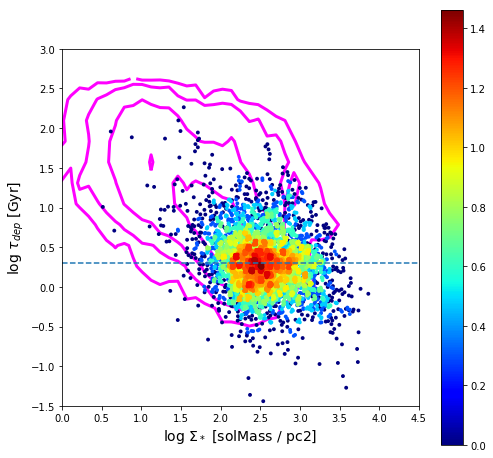

In [6]:
# Select data to plot (must be loggable)
not_nan = (~np.isnan(sig_star)) & (~np.isnan(t_dep)) & (sig_star>0) & (t_dep>0)
not_nan_ndet = (~np.isnan(sig_star_ndet)) & (~np.isnan(t_dep_ndet)) & (sig_star_ndet>0) & (t_dep_ndet>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_star[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_star_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], 
                                         log=True, bins=[50,50])
# Make the scatter plots
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_*$ ['+str(sig_star.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(0,4.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)

## Depletion time vs. local sSFR

Excluding 10 invalid values
Number of valid points: 4795


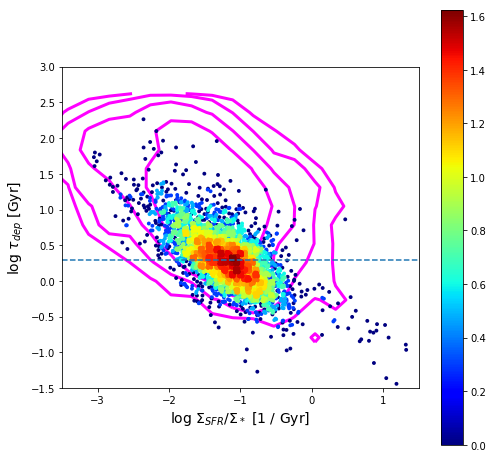

In [7]:
# Select data to plot (must be loggable)
not_nan = (np.isfinite(sig_ssfr)) & (np.isfinite(t_dep)) & (sig_ssfr>0) & (t_dep>0)
not_nan_ndet = (np.isfinite(sig_ssfr_ndet)) & (np.isfinite(t_dep_ndet)) & (sig_ssfr_ndet>0) & (t_dep_ndet>0)
print('Excluding {} invalid values'.format(len(np.nonzero(~not_nan)[0])))
print('Number of valid points:',len(np.nonzero(not_nan)[0]))

x_det, y_det, z_det, *hist = xy2hist(sig_ssfr[not_nan], t_dep[not_nan], log=True)
x_ndet, y_ndet, z_ndet, *hist2 = xy2hist(sig_ssfr_ndet[not_nan_ndet], 
                                         t_dep_ndet[not_nan_ndet], 
                                         log=True, bins=[50,50])
# Make the scatter plots
fig, ax = plt.subplots(figsize=(8,8))
cm = plt.cm.get_cmap('jet')
sc = ax.scatter(x_det, y_det, c=z_det, s=15, edgecolor='', cmap=cm)
ax.contour(hist2[0].transpose(),[10,30,100,300],
           extent=[hist2[1].min(),hist2[1].max(),
                   hist2[2].min(),hist2[2].max()],
           colors='magenta',linewidths=3,zorder=-1)
plt.xlabel(r'log $\Sigma_{SFR}$/$\Sigma_*$ ['+str(sig_ssfr.unit)+']',fontsize=14)
plt.ylabel(r'log $\tau_{dep}$ ['+str(t_dep.unit)+']',fontsize=14)
ax.set_aspect('equal')
ax.axhline(0.3, linestyle='--')
ax.set_xlim(-3.5,1.5)
ax.set_ylim(-1.5,3)
plt.colorbar(sc)